In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.read_pickle("../data/processed/uk_clean.pkl") #loads the processed UK data 

DV = "BEINGBULLIED" 
X = df.drop(columns = [DV, "CNTSCHID"]) #drop DV + School ID and has only features
y = df[DV].copy() #copy the dependent variable

X["ST004D01T"] = X["ST004D01T"].map({1:0, 2:1}) #maps male variable to 0 and female variable to 1

num_cols = X.columns.tolist() #stores the names of all features 

imputer = SimpleImputer(strategy = "median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns = num_cols, index = X.index) #fills in missing values using the median of each column 

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns = num_cols, index = X.index) #standardize the data so that mean = 0 and STD = 1

uk_final = X_scaled.copy() 
uk_final[DV] = y.values #combines the scaled features with the dependent variable back into single dataframe

out_final = Path("../data/processed/uk_clean_final.pkl") #saves data to a new file 
uk_final.to_pickle(out_final)
print(f"Saved final cleaned UK data → {out_final} (shape: {uk_final.shape})")

Saved final cleaned UK data → ..\data\processed\uk_clean_final.pkl (shape: (13818, 35))


In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

df = pd.read_pickle("../data/processed/uk_clean_final.pkl")
df = df.dropna(subset=["BEINGBULLIED"])

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

base_params = dict(
    n_estimators = 300,
    max_depth = 4,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = "reg:squarederror",
)

reg_parameters = {
    "gamma": [0, 0.1, 0.25, 0.5, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "reg_alpha": [0, 0.05, 0.15, 0.3, 0.6],   
    "reg_lambda": [0.5, 1, 2, 4, 6]         
}

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = RandomizedSearchCV(
    estimator= XGBRegressor(**base_params, random_state=42, verbosity=0),
    param_distributions = reg_parameters,
    n_iter = 64,
    cv = rkf,
    scoring = "neg_mean_absolute_error",
    n_jobs = -1,
    random_state = 42,
    verbose = 2
)

grid.fit(X, y)

best_mae   = -grid.best_score_
print("\nRegularisation-only best MAE:", round(best_mae, 3))
print("With regularisation params:")
for k, v in grid.best_params_.items():
    print(f"   {k:<16s}: {v}")


Fitting 10 folds for each of 64 candidates, totalling 640 fits

Regularisation-only best MAE: 0.725
With regularisation params:
   reg_lambda      : 4
   reg_alpha       : 0.6
   min_child_weight: 5
   gamma           : 0.1


In [ ]:
from xgboost import XGBRegressor
import pandas as pd

df = pd.read_pickle("../data/processed/uk_clean_final.pkl")  # loads the final cleaned Japan data
df = df.dropna(subset=["BEINGBULLIED"])  # drops rows with missing values in the dependent variable

X = df.drop(columns=["BEINGBULLIED"])
y = df["BEINGBULLIED"]

best_xgb = XGBRegressor(
    n_estimators = 300,
    max_depth = 4,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_lambda = 4,
    reg_alpha = 0.6, 
    min_child_weight = 5,
    objective = "reg:squarederror",
    gamma = 0,
    random_state = 42,
    verbosity = 0
)

best_xgb.fit(X, y)

importances = best_xgb.feature_importances_  # get feature importances
feat_imp = sorted(zip(X.columns, importances), key=lambda pair: pair[1], reverse=True)

print("Top 10 XGB predictors of BEINGBULLIED (UK):")
for feat, imp in feat_imp[:10]:
    print(f"  {feat:<12s}: {imp:.4f}")


Top 10 XGB predictors of BEINGBULLIED (UK):
  BELONG      : 0.2164
  GFOFAIL     : 0.0666
  ST004D01T   : 0.0583
  DISCLIMA    : 0.0470
  EUDMO       : 0.0381
  PERCOMP     : 0.0355
  EMOSUPS     : 0.0291
  RESILIENCE  : 0.0279
  COMPETE     : 0.0257
  PERCOOP     : 0.0256


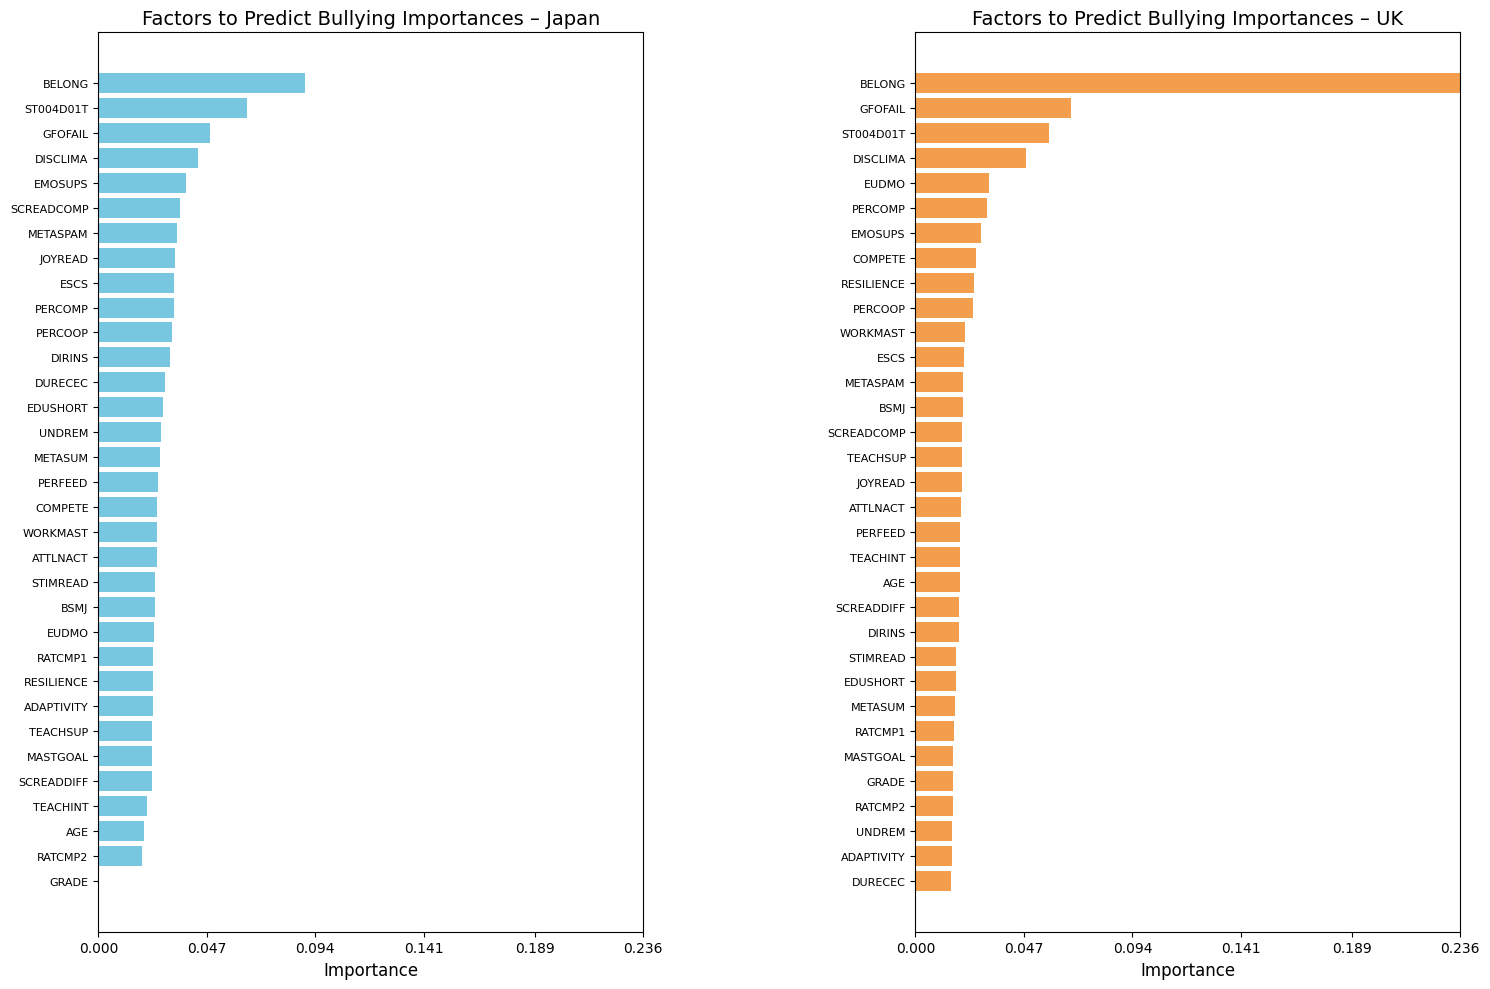

In [11]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

df_jpn = pd.read_pickle("../data/processed/japan_clean_final.pkl").dropna(subset=["BEINGBULLIED"])
df_uk  = pd.read_pickle("../data/processed/uk_clean_final.pkl").dropna(subset=["BEINGBULLIED"])

X_jpn, y_jpn = df_jpn.drop(columns=["BEINGBULLIED"]), df_jpn["BEINGBULLIED"]
X_uk,  y_uk  = df_uk.drop(columns=["BEINGBULLIED"]),  df_uk ["BEINGBULLIED"]

X_uk = X_uk[X_jpn.columns]

xgb_params = dict(
    n_estimators     = 300,
    max_depth        = 4,
    learning_rate    = 0.05,
    subsample        = 0.8,
    colsample_bytree = 0.8,
    reg_lambda       = 4,
    reg_alpha        = 0.6,
    min_child_weight = 5,
    gamma            = 0,
    objective        = "reg:squarederror",
    random_state     = 42,
    verbosity        = 0
)

model_jpn = XGBRegressor(**xgb_params).fit(X_jpn, y_jpn)
model_uk  = XGBRegressor(**xgb_params).fit(X_uk,  y_uk)

imp_jpn = model_jpn.feature_importances_
imp_uk  = model_uk .feature_importances_

feature_names = X_jpn.columns.tolist()

df_imp_jpn = (pd.DataFrame({"feature": feature_names, "importance": imp_jpn})
                .sort_values("importance", ascending=True))
df_imp_uk  = (pd.DataFrame({"feature": feature_names, "importance": imp_uk})
                .sort_values("importance", ascending=True))

max_imp = max(df_imp_jpn["importance"].max(), df_imp_uk["importance"].max())
xticks  = np.linspace(0, max_imp, 6).round(3)

fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True)

axes[0].barh(df_imp_jpn["feature"], df_imp_jpn["importance"], color="#78C7E0")
axes[0].set_title("Factors to Predict Bullying Importances – Japan",  fontsize=14)
axes[0].set_xlabel("Importance", fontsize=12)
axes[0].set_xlim(0, max_imp)
axes[0].set_xticks(xticks)
axes[0].tick_params(axis="y", labelsize=8)

axes[1].barh(df_imp_uk["feature"],  df_imp_uk["importance"],  color="#F29E4C")
axes[1].set_title("Factors to Predict Bullying Importances – UK",     fontsize=14)
axes[1].set_xlabel("Importance", fontsize=12)
axes[1].set_xlim(0, max_imp)
axes[1].set_xticks(xticks)
axes[1].tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.show()
